In [1]:
import numpy as np
import pandas as pd
import datetime
import mlcrate as mlc
import gc
import os

import time
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()
plt.style.use('ggplot')
%matplotlib inline

In [2]:
for file in os.listdir('../input'):
    if 'zip' not in file:
        print(file.ljust(30) + str(round(os.path.getsize('../input/' + file)/1000000,2)) + 'MB')

test_supplement.csv           2665.54MB
train_sample.csv              4.08MB
train.csv                     7537.65MB
sample_submission.csv         195.58MB
test.csv                      863.27MB


In [3]:
import subprocess
print('# Line count:')
for file in ['train.csv','test.csv','train_sample.csv']:
    lines = subprocess.run(['wc','-l','../input/{}'.format(file)],stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(lines,end='',flush=True)

# Line count:
184903891 ../input/train.csv
18790470 ../input/test.csv
100001 ../input/train_sample.csv


## Data overview

In [4]:
df_train = pd.read_csv('../input/train.csv',nrows=1000000)
df_test = pd.read_csv('../input/test.csv',nrows=1000000)

In [5]:
print('Training set:')
display(df_train.head())

Training set:


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [6]:
print('Test set:')
display(df_test.head())

Test set:


,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


### The meanings of columns

- ip: ip address of click
- app: app id for marketing
- device: device type id of user mobile phone (e.g., iphone6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad pubisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for aften clicking and ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded

No handles with labels found to put in legend.


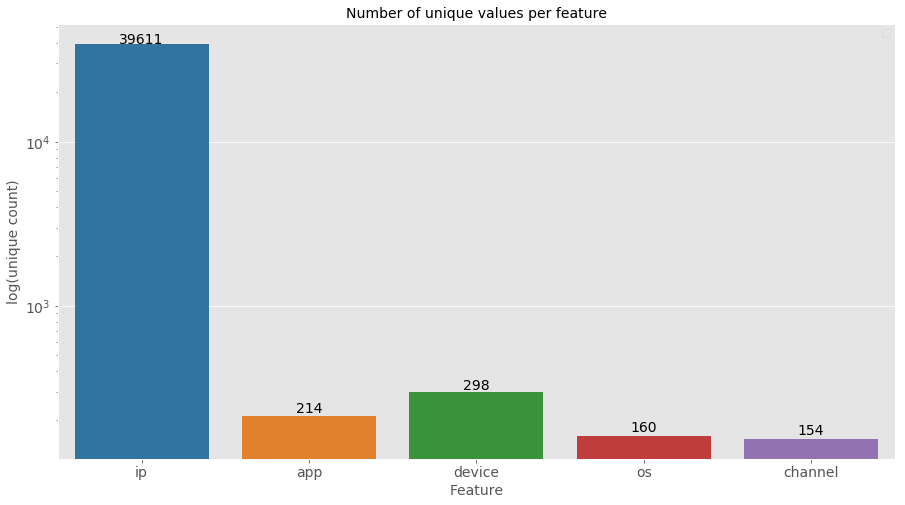

In [7]:
cols = ['ip','app','device','os','channel']
uniques = [len(df_train[col].unique()) for col in cols]

plt.figure(figsize=(15,8))
ax = sns.barplot(cols,uniques,log=True,palette=pal)
for p, uniq in zip(ax.patches,uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height+10,uniq,ha='center',fontsize=14)
plt.xlabel('Feature',fontsize=14)
plt.ylabel('log(unique count)',fontsize=14)
plt.title('Number of unique values per feature',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.show()

### Encoded variable statistics

In [8]:
counts = df_train['ip'].value_counts()
sorted_counts = np.sort(counts.values)

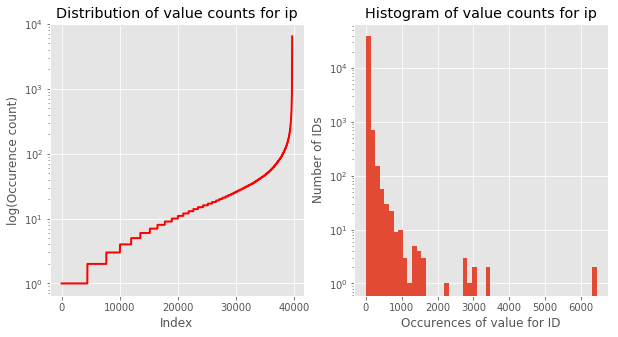

Variable 'ip': | Unique values: 39611 | Count of most common: 6437 | Count of least common: 1 | count>10: 49.56% | count>100: 3.98% | count>1000: 0.07%


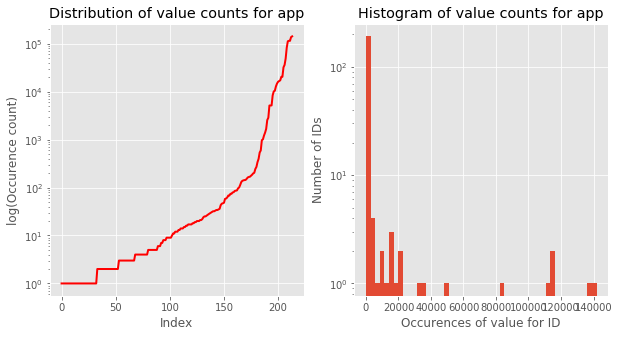

Variable 'app': | Unique values: 214 | Count of most common: 141851 | Count of least common: 1 | count>10: 51.87% | count>100: 22.9% | count>1000: 13.08%


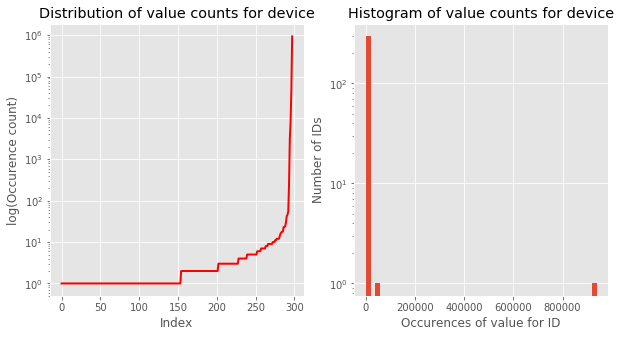

Variable 'device': | Unique values: 298 | Count of most common: 938053 | Count of least common: 1 | count>10: 7.72% | count>100: 1.68% | count>1000: 1.34%


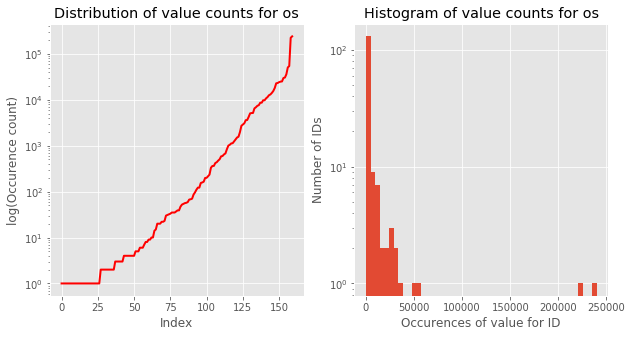

Variable 'os': | Unique values: 160 | Count of most common: 239642 | Count of least common: 1 | count>10: 60.0% | count>100: 41.88% | count>1000: 28.12%


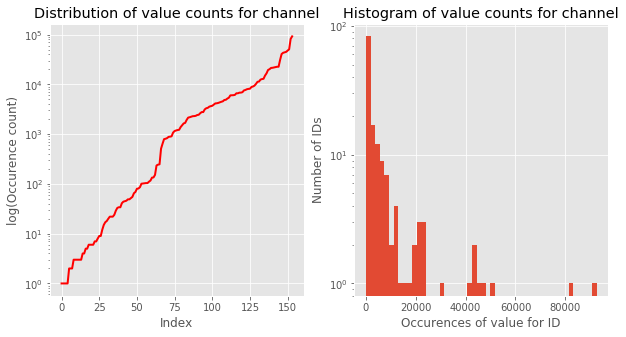

Variable 'channel': | Unique values: 154 | Count of most common: 92534 | Count of least common: 1 | count>10: 82.47% | count>100: 65.58% | count>1000: 51.95%


In [9]:
for col,uniq in zip(cols,uniques):
    counts = df_train[col].value_counts()
    sorted_counts = np.sort(counts.values)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    line, = ax.plot(sorted_counts,color='red',linewidth=2)
    ax.set_yscale('log')
    plt.title('Distribution of value counts for {}'.format(col))
    plt.ylabel('log(Occurence count)')
    plt.xlabel('Index')

    ax = fig.add_subplot(1,2,2)
    plt.hist(sorted_counts,bins=50)
    ax.set_yscale('log',nonposy='clip')
    plt.title('Histogram of value counts for {}'.format(col))
    plt.ylabel('Number of IDs')
    plt.xlabel('Occurences of value for ID')
    plt.show()
    
    max_count = np.max(counts)
    min_count = np.min(counts)
    gt = [10,100,1000]
    prop_gt = []
    for value in gt:
        prop_gt.append(round((counts > value).mean()*100, 2))
    print("Variable '{}': | Unique values: {} | Count of most common: {} | Count of least common: {} | count>10: {}% | count>100: {}% | count>1000: {}%".format(col, uniq, max_count, min_count, *prop_gt))

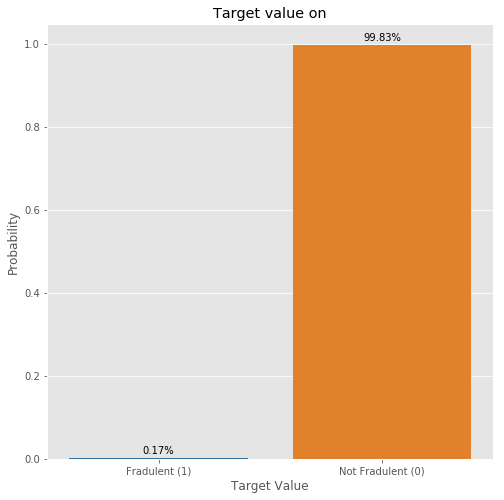

In [10]:
plt.figure(figsize=(8,8))
mean = (df_train['is_attributed']==1).mean()
ax = sns.barplot(['Fradulent (1)','Not Fradulent (0)'],[mean,1-mean],palette=pal)
ax.set(xlabel='Target Value',ylabel='Probability',title='Target value on')
for p, uniq in zip(ax.patches,[mean,1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height+0.01,'{}%'.format(round(uniq*100,2)),ha='center')